<a href="https://colab.research.google.com/github/nyp-sit/sdaai-pdc2-students/blob/master/iti107/session-3/improved_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" align="left"/></a>

# Simpsons Characters recognition using transfer learning (VGG19)

The Simpsons Characters dataset is obtained from https://www.kaggle.com/alexattia/the-simpsons-characters-dataset.
I only used 23 characters from the dataset. There are 13495 images for the 23 characters.

I use transfer learning in the  baseline model for this experiment. I make use of the model (VGG19) that is already trained on ImageNet and use the convolutional layers as feature extractor and trained a classifier specifically for the Simpsons Characters classification task. The training was done using Nvidia GTX 1660 TI GPU.


In [1]:
from __future__ import print_function

import os
import json
import shutil
import numpy as np

from utils import prepare_data


import tensorflow as tf

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, \
                            precision_recall_curve, average_precision_score, confusion_matrix
import pickle
import matplotlib
import matplotlib.pyplot as plt


gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

%matplotlib inline

## Prepare Data

Unzip the temp_data.zip into a temp_data folder. The utils.py will split the images to training and validation sets.

In [2]:
data_path = "data"
models_path = "models"
valid_size = 0.2
FORCED_DATA_REWRITE = False

In [3]:
train_path, valid_path = prepare_data(data_path=data_path, 
                                      valid_size=valid_size, 
                                      FORCED_DATA_REWRITE=FORCED_DATA_REWRITE)

In [4]:
img_height, img_width = 300, 400

## Pre-trained Model as Feature Extractor

I use VGG19 as our pretrained model (you can choose any other pretrained model, such as ResNet, etc). Keras comes with a set of [pretrained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications) you can choose from. In the following call, I load the model VGG19 without including the classification layers (`include_top=False`). For the weights, I specify to use the weights that was trained on ImageNet dataset.

In [5]:
conv_base = VGG19(include_top=False, 
                         weights="imagenet",  
                         input_shape=(img_height, img_width, 3))

conv_base.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 400, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 100, 128)      0     

In [6]:
model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=23, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 9, 12, 512)        20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                11799     
Total params: 20,298,839
Trainable params: 20,298,839
Non-trainable params: 0
_________________________________________________________________


In [7]:
conv_base.trainable = True
# only unfreeze the last conv block (block5_convx) 
for layer in conv_base.layers:
    #if layer.name in ['block5_conv4']:
    #    layer.trainable = True
  
    if layer.name not in ['block5_conv1','block5_conv2','block5_conv3', 'block5_conv4']:
        layer.trainable = False

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 9, 12, 512)        20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 23)                11799     
Total params: 20,298,839
Trainable params: 9,713,687
Non-trainable params: 10,585,152
_________________________________________________________________


In [9]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=Adam(lr=0.0001),
              metrics=["accuracy"])

In [10]:
datagen = ImageDataGenerator(rescale=1. / 255)



In [11]:
train_gen = datagen.flow_from_directory(train_path, 
                                        target_size=(img_height, img_width), 
                                        class_mode='binary', 
                                        batch_size=4, 
                                        shuffle=False)

valid_gen = datagen.flow_from_directory(valid_path, 
                                        target_size=(img_height, img_width), 
                                        class_mode='binary', 
                                        batch_size=4, 
                                        shuffle=False)

Found 10806 images belonging to 23 classes.
Found 2689 images belonging to 23 classes.


In [12]:
train_gen.class_indices

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22}

In [13]:
train_steps_per_epoch = int(np.ceil(train_gen.n * 1. / train_gen.batch_size))
valid_steps_per_epoch = int(np.ceil(valid_gen.n * 1. / valid_gen.batch_size))

In [14]:
print(train_steps_per_epoch)

2702


In [15]:
print(valid_steps_per_epoch)

673


In [16]:
history = model.fit(
      train_gen,
      steps_per_epoch=train_steps_per_epoch,
      epochs=10,
      validation_data=valid_gen, 
      validation_steps=valid_steps_per_epoch,
      verbose=1)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2702 steps, validate for 673 steps
Epoch 1/10
2702/2702 [==============================] - 401s 149ms/step - loss: 1.9256 - accuracy: 0.4311 - val_loss: 0.7503 - val_accuracy: 0.8144
Epoch 2/10
2702/2702 [==============================] - 396s 147ms/step - loss: 0.5914 - accuracy: 0.8524 - val_loss: 0.4381 - val_accuracy: 0.8866
Epoch 3/10
2702/2702 [==============================] - 400s 148ms/step - loss: 0.3774 - accuracy: 0.9022 - val_loss: 0.3571 - val_accuracy: 0.9085
Epoch 4/10
2702/2702 [==============================] - 402s 149ms/step - loss: 0.2717 - accuracy: 0.9283 - val_loss: 0.3933 - val_accuracy: 0.9104
Epoch 5/10
2702/2702 [==============================] - 403s 149ms/step - loss: 0.2119 - accuracy: 0.9458 - val_loss: 0.3132 - val_accuracy: 0.9305
Epoch 6/10
2702/2702 [==============================] - 403s 149ms/step - loss: 0.1575 - accuracy: 0.9597 - val_loss: 0.3687 - val_accuracy: 0.9290
Epoch 7/10
2702/2

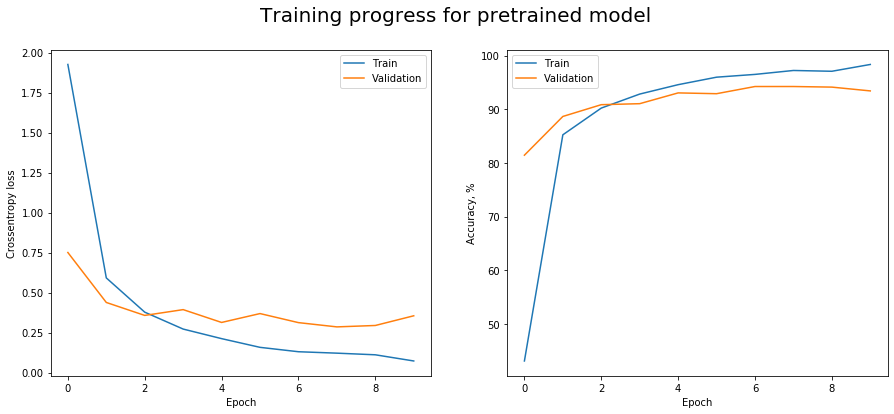

In [17]:
plt.figure(figsize=(15, 6))
plt.suptitle("Training progress for pretrained model", fontsize=20)

plt.subplot(121)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.legend()
plt.ylabel("Crossentropy loss")
plt.xlabel("Epoch")

plt.subplot(122)
plt.plot(np.array(history.history["accuracy"]) * 100, label="Train")
plt.plot(np.array(history.history["val_accuracy"]) * 100, label="Validation")
plt.legend()
plt.ylabel("Accuracy, %")
plt.xlabel("Epoch");

In [22]:
y_pred = model.predict(valid_gen)
y_valid = np.array(valid_gen.classes)

In [23]:
y_pred = np.argmax(y_pred, axis = 1)
print(classification_report(y_valid, y_pred))
print("Accuracy = {:.1f}%".format(accuracy_score(y_valid, y_pred) * 100))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       182
           1       1.00      0.12      0.22         8
           2       0.94      0.97      0.96       124
           3       1.00      0.52      0.69        21
           4       0.97      0.96      0.96       268
           5       1.00      0.74      0.85        19
           6       0.97      0.93      0.95       238
           7       0.94      0.95      0.95       197
           8       0.90      1.00      0.95         9
           9       0.94      0.88      0.91        93
          10       0.00      0.00      0.00         1
          11       0.98      0.93      0.96        91
          12       0.80      0.80      0.80         5
          13       1.00      0.60      0.75         5
          14       0.35      0.92      0.51        24
          15       0.88      0.95      0.92       449
          16       0.92      0.99      0.96        99
          17       1.00    

D:\Anaconda3\envs\tf2-gpu\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, preprocess_input_fn, target_size=(img_height, img_width)):
    img = image.load_img(img_path, target_size=target_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input_fn(x)
    preds = model.predict(x)

    return preds

In [32]:
img_path = 'data/test/bart_simpson_2.jpg'
pred_class = np.argmax(predict_image(model, img_path, preprocess_input), axis=1)[0]
target_names = list(train_gen.class_indices.keys())
print(target_names[pred_class])

bart_simpson
